In [11]:
import sys
sys.path.append("..") # import one subdirectory up in files
#sys.path.append("..") # import one subdirectory up in files
#os.chdir("../holopy/")

# standard imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('qt5agg')
import time as time
#import json
import pickle

# 3rd party packages
import qiskit as qk
import qiskit.providers.aer.noise as noise
import tenpy as tp

## custom things
from networks.networks import IsoMPS
from networks.isonetwork import QKParamCircuit
import circuits.basic_circuits as circuits

In [12]:
## TENPY FUNCTION DEFINITIONS ##
def xxz_mpo(J=1.0, Delta=1.0, hz=0.0, N=1, bc='infinite'):
    site = tp.networks.site.SpinHalfSite(None)
    Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, 2*site.Sz
    W_bulk = [[Id, Sp, Sm, Sz, -hz * Sz],
              [None, None, None, None, 0.5 * J * Sm],
              [None, None, None, None, 0.5 * J * Sp],
              [None, None, None, None, J * Delta * Sz],
              [None, None, None, None, Id]]
    H = tp.networks.mpo.MPO.from_grids([site], [W_bulk], bc, IdL=0, IdR=-1) # (probably leave the IdL,IdR)
    return H

# tenpy energy calculator
def energy_tp(param_vals,*args):
    """
    function to calculate energy using MPO/MPS contraction in tenpy
    inputs:
        - param_vals = dict {parameter:value}
        - *args, 
            args[0] should be psi: state as IsoMPS
            args[1] should be H_mpo: Hamiltonian as MPO
        (input made this way to be compatible w/ scipy.optimize)
    outputs:
        - float, <psi|H|psi> computed w/ tenpy
    """
    # parse inputs
    psi=args[0] # state as isoMPS    
    H_mpo = args[1] # Hamiltonian as tenpy MPO
    param_dict = dict(zip(psi.param_list,param_vals))
    
    # convert state from holoPy isoMPS to tenpy MPS
    psi_tp = psi.to_tenpy(param_dict,L=np.inf)
    
    # compute energy
    E = (H_mpo.expectation_value(psi_tp)).real
    return E

In [13]:
## HYPERPARAMETERS ##
# model (xxz)
J = 1.0 # spin-exchange
Delta = 1.5 # Ising-anisotropy
hz = 0.0 # z-field

# ansatz parameters
nb = 1 # number of bond-qubits 
L = 1 # number of unit cells
l_uc = 2 # number of sites in unit cell
n_site_param = 2*nb # number of circuit parameters per site
# number of bond circuit parameters
if nb==1: n_bond_params=3
elif nb==2: n_bond_params=15 

example site circuit:
site 0
site 1


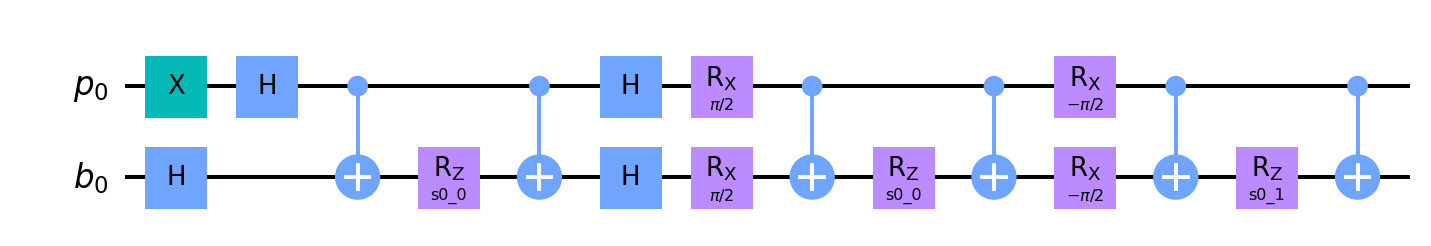

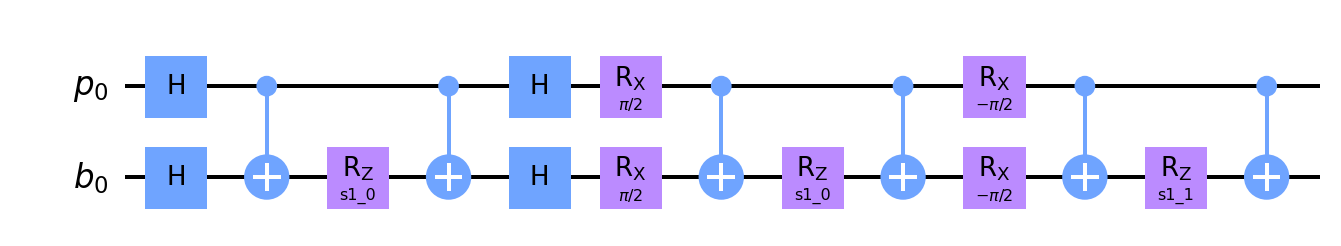

In [14]:
## CREATE ISOMPS FROM PARAMETERIZED CIRCUIT ANSATZ ##
# initialize registers
preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(nb,'b') # bond qubits
#creg = qk.ClassicalRegister(L*l_uc+nb,'m') # classical register to hold measurement outcomes

## Bond-state prep-circuit ##
bond_prep_params = [qk.circuit.Parameter('bp_'+str(j)) 
                    for j in range(n_bond_params)]
bond_prep_circ = qk.QuantumCircuit(breg)
if nb==1: circuits.add_1q_circ(bond_prep_circ, breg[0], bond_prep_params) 
elif nb==2: circuits.add_su4_circ(bond_prep_circ, breg[0],breg[1], bond_prep_params) 

# turn into custom parameterized circuit object
bond_prep_pcirc = QKParamCircuit(bond_prep_circ,bond_prep_params)


## Site Circuits ##
# create list of circuits, one for each site in the unit cell (uc)
site_circs = [qk.QuantumCircuit(preg,breg) for j in range(l_uc)]
# create a list of parameter-lists, (one list of parameters per site in uc)
site_circ_params = [[qk.circuit.Parameter('s'+str(j)+'_'+str(k))
                     for k in range(n_site_param)] 
                    for j in range(l_uc)]
site_pcircs=[] # list of QKParamCirc's for each site in uc
for j in range(l_uc):
    if j%2==0: site_circs[j].x(preg[0]) # alternating 10101010... for physical qubit
    
    # star circuit of xxz-type 2-qubit gates
    for k in range(nb): 
        circuits.add_xxz_circ(site_circs[j], 
                              preg[0], breg[k], 
                              site_circ_params[j][2*k:2*(k+1)])
    # combine into parameterized circuit
    site_pcircs += [QKParamCircuit(site_circs[j], site_circ_params[j])]

# create holopy isoMPS
psi = IsoMPS(preg,breg,site_pcircs,boundary_circuit=bond_prep_pcirc)

print('circuits for each site in uc')
for j in range(l_uc):
    site_circs[j].draw('mpl')
    ax.show()

In [5]:
## OPTIMIZE CIRCUIT PARAMETERS CLASSICALLY IN TENPY ##
# create tenpy mpo
H_mpo = xxz_mpo(J=J,hz=hz,Delta=Delta,N=1)


x0 = 0.03*np.random.randn(psi.n_params) # starting point for parameters
t0 = time.time()
opt_result = minimize(energy_tp, # function to minimize
                      x0, # starting point for parameters 
                      args=(psi,H_mpo), # must take form (isoMPS,tenpy MPO)
                      method='BFGS'
                     )
tf = time.time()
# set parameters to previously optimized values
opt_vals = opt_result.x
opt_params = dict(zip(psi.param_list,opt_vals))

print('Optimization done, elapsed time: {}'.format(tf-t0))
print('Optimized energy = {}'.format(opt_result.fun))

Optimization done, elapsed time: 18.529865980148315
Optimized energy = -1.9999999999922387
